This notebook which contains the code for training 3D custom model and 3D MobileNet model.

In [1]:
!pip install  python-gdcm 
!pip install pylibjpeg pylibjpeg-libjpeg 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 25.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 7.8 MB/s eta 0:00:00a 0:00:010m


In [2]:
#importing all the necessary libraries
import os
import numpy as np
import pandas as pd
import torch
import pydicom as dicom
import pylibjpeg
import gdcm
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset,DataLoader
from pydicom.pixel_data_handlers.util import apply_voi_lut
import numpy as np
import os
import pandas as pd
from PIL import Image
import torch.nn as nn

In [3]:
#setting the device as cuda if available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# reading the training csv file
data= pd.read_csv('../input/rsna-2022-cervical-spine-fracture-detection/train.csv',index_col=False)

In [5]:
data

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
2014,1.2.826.0.1.3680043.21684,1,0,1,0,0,0,1,1
2015,1.2.826.0.1.3680043.4786,1,0,0,0,0,0,0,1
2016,1.2.826.0.1.3680043.14341,0,0,0,0,0,0,0,0
2017,1.2.826.0.1.3680043.12053,0,0,0,0,0,0,0,0


In [6]:
#reading a dicom file
med= dicom.read_file('../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.6200/240.dcm')

In [7]:
med
#viewing the content of the dicom file. we can see various meta data associated with the given scan images

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.6200.1.240
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.6200.1.240
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '185002.042922'
(0010, 0010) Patient's Name                      PN: '6200'
(0010, 0020) Patient ID                          LO: '6200'
(0018, 0050) Slice Thickness                     DS: '1.0'
(00

In [8]:
class RSNAImageDataset(Dataset):
    def __init__(self, image_file, img_dir, transform=None,target_transform=None):
        self.img_data = pd.read_csv(image_file) # reading the images from 
        self.img_dir = img_dir # storing the directory of the images 
        self.transform = transform # data augmentation to be applied on the training images
        self.target_transform=target_transform # data augmentation to applied on the target

    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):
        
        for dirname, _, filenames in os.walk(os.path.join(self.img_dir, self.img_data.iloc[idx].StudyInstanceUID)):
                images=[]
                ys=[]
                l=0
                for filename in filenames:
                    dc=dicom.read_file(os.path.join(os.path.join(self.img_dir, self.img_data.iloc[idx].StudyInstanceUID), filename))
                    dc.PhotometricInterpretation = 'YBR_FULL'
                    image = dc.pixel_array  # reading the image
                    image =image.astype(np.float32) # reading it in the float32 for simplicity
                    image = Image.fromarray(image) # converting to PIL Image for applying the transformations
                    label = self.img_data.iloc[idx][['patient_overall','C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']] # entire label set of the given image
                    label = (label.values).astype(np.float32) # converting to float32 for simplicity
                    if self.transform:
                        image = self.transform(image)
                    images.append(torch.reshape(image,(1,224,224))) # converting to 100 * 100 size image
                    l+=1
                    if l>64:
                        break
        X_train = torch.stack(images,axis=0)
        X_train = X_train.permute(1,0,2,3) # making it in the form of b*c*h*w
        label=torch.from_numpy(label) # convert to tensor
        return X_train, label # returning the image and their corresponding label. 

In [9]:
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.Resize((224,224)), # resize the image into 100 * 100
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5000], std=[.1000]),# normalizing the image
])
target_transform = transforms.Compose([
    transforms.ToTensor(),
])
Image_set = RSNAImageDataset('../input/rsna-2022-cervical-spine-fracture-detection/train.csv','../input/rsna-2022-cervical-spine-fracture-detection/train_images',transform=transform,target_transform=target_transform)
test_size = int(0.3 * len(Image_set)) # 30 % for validation set and 70% for training set
train_size = len(Image_set) - test_size
train_seg,val_seg= torch.utils.data.random_split(Image_set,[train_size,test_size]) # dividing into training and validation set
D_train_load = DataLoader(train_seg, batch_size=2, shuffle=True,pin_memory=True,drop_last=True)#train dataloader
D_test_load = DataLoader(val_seg, batch_size=2, shuffle=True,pin_memory=True,drop_last=True)#test dataloader

In [10]:
train_features, train_labels = next(iter(D_train_load))

In [11]:
train_features.shape

torch.Size([2, 1, 65, 224, 224])

In [10]:
from torch.nn import BCELoss
# the competiton loss defined in the RSNA Competition
def competiton_loss(y_true, y_pred):

    competition_weights = {
        '-' : torch.tensor([7, 1, 1, 1, 1, 1, 1, 1], dtype=torch.float32,device=DEVICE),
        '+' : torch.tensor([14, 2, 2, 2, 2, 2, 2, 2], dtype=torch.float32, device=DEVICE)
    } #weights for each label for both positive and negative classes
    losses=BCELoss()
    loss = losses(y_true,y_pred)
    weights  = y_true*competition_weights['+'] + (1-y_true)*competition_weights['-'] # weighted BCE loss
    loss = (loss * weights).sum(axis=1)
    loss = loss.mean()
    loss = loss / weights.sum(axis=1)
    return loss # returing the loss

In [15]:
class Depth(nn.Module):
    def __init__(self,in_ch,s=1):
        super(Depth,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv3d(in_channels=in_ch, out_channels=in_ch,groups=in_ch,kernel_size=3, stride=s, padding=1,bias=False),
            nn.BatchNorm3d(num_features=in_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self,inputs):
        out =self.layer(inputs)
        return out
class Point(nn.Module):
    def __init__(self,in_ch,out_ch,s=1):
        super(Point,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv3d(in_channels=in_ch, out_channels=out_ch,kernel_size=1,padding=0,bias=False),
            nn.BatchNorm3d(num_features=out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self,inputs):
        out = self.layer(inputs)
        return out
class Point_Depth(nn.Module):
    def __init__(self,in_ch,out_ch,s=1):
        super(Point_Depth,self).__init__()
        self.layer = nn.Sequential(
            Depth(in_ch,s),
            Point(in_ch,out_ch)
        )
    def forward(self,inputs):
        out = self.layer(inputs)
        return out
class MobileNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 =  nn.Conv3d(in_channels=1, out_channels=32,kernel_size=3,padding=1,stride=2,bias=False)
        self.norm1 = nn.BatchNorm3d(num_features=32)
        self.relu = nn.ReLU(inplace=True)
        self.layers = nn.Sequential(
            Point_Depth(32,64,1),
            Point_Depth(64,128,2),
            Point_Depth(128,128,1),
            Point_Depth(128,256,2),
            Point_Depth(256,256,1),
            Point_Depth(256,512,2),
            Point_Depth(512,512,1),
            Point_Depth(512,512,1),
            Point_Depth(512,512,1),
            Point_Depth(512,512,1),
            Point_Depth(512,512,1),
            Point_Depth(512,512,1),
            Point_Depth(512,1024,2),
            Point_Depth(1024,1024,2)
        )
        self.pool=  nn.AdaptiveAvgPool3d(1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(1024, 8)
        self.sig  = nn.Sigmoid()
    def forward(self,inputs):
        out = self.conv1(inputs)
        out = self.norm1(out)
        out = self.relu(out)
        out = self.layers(out)
        out = self.pool(out)
        out = self.flatten(out)
        out = self.fc(out)
        out = self.sig(out)
        
        return out

In [14]:
model = MobileNet().to(DEVICE)
optimiser = optim.AdamW(params=model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, max_lr=0.001, steps_per_epoch=len(D_train_load), epochs=50)

In [11]:
# 3D convolutional neural network
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__() 
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.norm1 = nn.BatchNorm3d(num_features=16)
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.norm2 = nn.BatchNorm3d(num_features=16)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.norm3 = nn.BatchNorm3d(num_features=32)
        self.conv4 = nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.norm4 = nn.BatchNorm3d(num_features=32)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
#         self.conv5 = nn.Conv3d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
#         self.norm5 = nn.BatchNorm3d(num_features=128)
#         self.conv6 = nn.Conv3d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
#         self.norm6 = nn.BatchNorm3d(num_features=128)
#         self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        self.avg = nn.AdaptiveAvgPool3d((7, 1, 1))
        self.flat = nn.Flatten()
        self.relu = nn.ReLU()
        self.lin1 = nn.Linear(in_features=224, out_features=64)
        self.lin2 = nn.Linear(in_features=64, out_features=8)
        self.sig  = nn.Sigmoid()
    def forward(self, x):
        # Conv block 1
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.pool1(out)
        
        # Conv block 2
        out = self.conv3(out)
        out = self.norm3(out)
        out = self.relu(out)
        out = self.conv4(out)
        out = self.norm4(out)
        out = self.relu(out)
        out = self.pool2(out)
#         out = self.norm2(out)
        
        # Conv block 3
#         out = self.conv5(out)
#         out = self.relu(out)
#         out = self.norm5(out)
#         out = self.conv6(out)
#         out = self.relu(out)
#         out = self.norm6(out)
#         out = self.pool3(out)
        
        # Average & flatten
        out = self.avg(out)
        out = self.flat(out)
        out = self.lin1(out)
        out = self.relu(out)
        
        # Output layer (no sigmoid needed)
        out = self.lin2(out)
        
        out =self.sig(out)
        
        return out


In [12]:
model = CustomModel().to(DEVICE)
optimiser = optim.AdamW(params=model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, max_lr=0.001, steps_per_epoch=len(D_train_load), epochs=60)

In [28]:
import sys
early_stopping_threshold=3
valid_min_loss=sys.maxsize
early_stopping = True
train_losses=[]
valid_losses=[]
for epoch in range(50):
    loss_acc = 0
    val_loss_acc = 0
    train_count = 0
    valid_count = 0
    model.train()
    # Loop over batches
    for imgs, labels in D_train_load:
        # Send to device
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        preds = model(imgs)
        
#         print( labels)
#         print(preds)
        L = competiton_loss(preds, labels)

        # Backprop
        L.sum().backward()
        optimiser.step()
        scheduler.step()

        # Zero gradients
        optimiser.zero_grad()
        
        # Track loss
#         print(L.detach())
        loss_acc += L.mean().item()
        train_count += 1
    model.eval() 
    for data in D_test_load: 
                inputs, outs = data 
                inputs, outs = inputs.to(DEVICE), outs.to(DEVICE)
                pred = model(inputs) 
                L = competiton_loss(preds, outs)
#                 L.sum().backward()
                val_loss_acc+= L.mean().item()
                valid_count+=1
    cur_train_loss=loss_acc/train_count
    cur_val_loss = val_loss_acc/valid_count
    train_losses.append(cur_train_loss)
    valid_losses.append(cur_val_loss)
    
    print(valid_min_loss)
    print(cur_val_loss)
    if cur_val_loss < valid_min_loss: 
            print("<<<< Saving >>>>")
            no_change = 0
            valid_min_loss = cur_val_loss
            save_dictionary ={}
            save_dictionary['model'] = model.state_dict()
            torch.save(save_dictionary, 'model.pth')

    else:
            no_change+=1
        
    if no_change > early_stopping_threshold and early_stopping:
            print('###### Early Stopping ######')
            break         
    
    print("epoch: ",epoch," train_loss: ",loss_acc/train_count," val_loss: ",val_loss_acc/valid_count)

9223372036854775807
0.6342125799920824
<<<< Saving >>>>
epoch:  0  train_loss:  0.6525953645291536  val_loss:  0.6342125799920824
0.6342125799920824
0.5917297270562913
<<<< Saving >>>>
epoch:  1  train_loss:  0.611195242923239  val_loss:  0.5917297270562913
0.5917297270562913
0.5520160529348586
<<<< Saving >>>>
epoch:  2  train_loss:  0.5682169782078784  val_loss:  0.5520160529348586
0.5520160529348586
0.5111463301711612
<<<< Saving >>>>
epoch:  3  train_loss:  0.5211251740870269  val_loss:  0.5111463301711612
0.5111463301711612
0.47026296456654865
<<<< Saving >>>>
epoch:  4  train_loss:  0.4712154165558193  val_loss:  0.47026296456654865
0.47026296456654865
0.45850661728117204
<<<< Saving >>>>
epoch:  5  train_loss:  0.4340488185053286  val_loss:  0.45850661728117204
0.45850661728117204
0.4504530330499013
<<<< Saving >>>>
epoch:  6  train_loss:  0.4222612989985425  val_loss:  0.4504530330499013
0.4504530330499013
0.46112393339474994
epoch:  7  train_loss:  0.4213251659403677  val_loss

In [25]:
import matplotlib.pyplot as plt
x = np.arange(1,len(train_losses)+1)

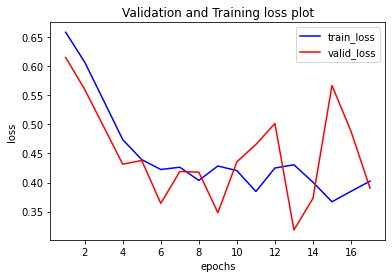

In [29]:
plt.plot(x,train_losses,c='b',label= "train_loss")
plt.plot(x,valid_losses,c='r',label="valid_loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Validation and Training loss plot')
plt.legend()
plt.show()

In [29]:
import matplotlib.pyplot as plt
x = np.arange(1,len(train_losses)+1)

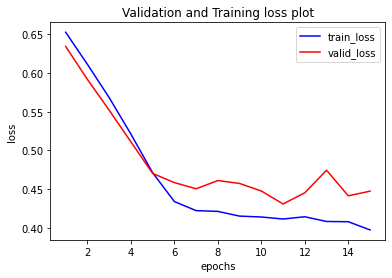

In [30]:
plt.plot(x,train_losses,c='b',label= "train_loss")
plt.plot(x,valid_losses,c='r',label="valid_loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Validation and Training loss plot')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics  import multilabel_confusion_matrix
test_loader = DataLoader(val_seg, batch_size=2, shuffle=True,pin_memory=True,drop_last=True)

In [25]:
test_image, test_label = next(iter(test_loader))

In [14]:
checkpoint = torch.load('/kaggle/input/models-final/models.pth')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [19]:
y_test=[]
pred_test=[]
for data in D_test_load:
    test_image, test_label=data
    test_image = test_image.to(DEVICE)
    y_pred = model(test_image)
    print(y_pred)
    y_pred[y_pred>=0.25]=1
    y_pred[y_pred<0.25]=0
    ar1=test_label.cpu().data.numpy()
    ar2=y_pred.cpu().data.numpy()
    for x in ar1:
        y_test.append(x)
    for x in ar2:
        pred_test.append(x)
# test_label = test_label.to(DEVICE)
multilabel_confusion_matrix(y_test,pred_test)

tensor([[0.5739, 0.1045, 0.1663, 0.0542, 0.1105, 0.1105, 0.1821, 0.2510],
        [0.5109, 0.1238, 0.1921, 0.0863, 0.2006, 0.1803, 0.2339, 0.2554]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.5330, 0.1020, 0.1587, 0.0767, 0.1736, 0.1419, 0.2379, 0.2158],
        [0.5922, 0.1205, 0.2058, 0.0734, 0.1564, 0.1400, 0.2327, 0.2868]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.5254, 0.0962, 0.1515, 0.0624, 0.1548, 0.1399, 0.2014, 0.2269],
        [0.5407, 0.1574, 0.2150, 0.1030, 0.1872, 0.1785, 0.2563, 0.2865]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.5385, 0.1480, 0.2208, 0.0918, 0.1800, 0.1745, 0.2384, 0.2926],
        [0.5285, 0.0782, 0.1261, 0.0499, 0.1296, 0.1143, 0.1806, 0.2063]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.5201, 0.1102, 0.1707, 0.0819, 0.1881, 0.1649, 0.2367, 0.2370],
        [0.5838, 0.1196, 0.1995, 0.0736, 0.1595, 0.1373, 0.2264, 0.2802]],
       device='cuda:0', grad_fn=<SigmoidBackwar

array([[[ 0,  5],
        [ 0, 13]],

       [[15,  1],
        [ 2,  0]],

       [[14,  1],
        [ 3,  0]],

       [[17,  1],
        [ 0,  0]],

       [[15,  1],
        [ 2,  0]],

       [[16,  0],
        [ 1,  1]],

       [[13,  1],
        [ 3,  1]],

       [[ 4,  8],
        [ 2,  4]]])

In [19]:
y_test=[]
pred_test=[]
for data in D_test_load:
    test_image, test_label=data
    test_image = test_image.to(DEVICE)
    y_pred = model(test_image)
    print(y_pred)
    y_pred[y_pred>=0.25]=1
    y_pred[y_pred<0.25]=0
    ar1=test_label.cpu().data.numpy()
    ar2=y_pred.cpu().data.numpy()
    for x in ar1:
        y_test.append(x)
    for x in ar2:
        pred_test.append(x)
# test_label = test_label.to(DEVICE)
multilabel_confusion_matrix(y_test,pred_test)

tensor([[0.5739, 0.1045, 0.1663, 0.0542, 0.1105, 0.1105, 0.1821, 0.2510],
        [0.5109, 0.1238, 0.1921, 0.0863, 0.2006, 0.1803, 0.2339, 0.2554]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.5330, 0.1020, 0.1587, 0.0767, 0.1736, 0.1419, 0.2379, 0.2158],
        [0.5922, 0.1205, 0.2058, 0.0734, 0.1564, 0.1400, 0.2327, 0.2868]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.5254, 0.0962, 0.1515, 0.0624, 0.1548, 0.1399, 0.2014, 0.2269],
        [0.5407, 0.1574, 0.2150, 0.1030, 0.1872, 0.1785, 0.2563, 0.2865]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.5385, 0.1480, 0.2208, 0.0918, 0.1800, 0.1745, 0.2384, 0.2926],
        [0.5285, 0.0782, 0.1261, 0.0499, 0.1296, 0.1143, 0.1806, 0.2063]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.5201, 0.1102, 0.1707, 0.0819, 0.1881, 0.1649, 0.2367, 0.2370],
        [0.5838, 0.1196, 0.1995, 0.0736, 0.1595, 0.1373, 0.2264, 0.2802]],
       device='cuda:0', grad_fn=<SigmoidBackwar

array([[[ 0,  5],
        [ 0, 13]],

       [[15,  1],
        [ 2,  0]],

       [[14,  1],
        [ 3,  0]],

       [[17,  1],
        [ 0,  0]],

       [[15,  1],
        [ 2,  0]],

       [[16,  0],
        [ 1,  1]],

       [[13,  1],
        [ 3,  1]],

       [[ 4,  8],
        [ 2,  4]]])